In [1]:
%pylab inline
import scipy
import sys
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble as Ass
#from topology.PatchMesh3D_2 import *
#from multipatch import *

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def PoissonEstimator(MP,f,uh):
    n = MP.mesh.numpatches
    indicator = np.zeros(n)
    params = {'f': f}
    
    uh_per_patch = dict()
    
    #residual contribution
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        
        h = np.linalg.norm([b-a for a,b in geo.bounding_box()])
        
        N = tuple(kv.numdofs for kv in kvs)
        uh_per_patch[p] = (MP.global_to_patch(p) @ uh).reshape(N)   #cache Spline Function on patch p
        
        params['geo'] = geo
        params['uh_func'] = geometry.BSplineFunc(kvs, uh_per_patch[p])
        
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        indicator[p] = h**2 * np.sum(Ass.assemble('(f + div(grad(uh_func)))**2 * v * dx', kvs0, params))
        
    params = dict()
    
    #flux contribution
    for i,((p1,b1,_), (p2,b2,_), _, flip) in enumerate(MP.intfs):
        #print(p1, p2, flip)
        
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = Ass.int_to_bdspec(b1), Ass.int_to_bdspec(b2)
        
        bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)

        geo = geo2.boundary(bdspec2)
        params['geo'] = geo
        
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        h = np.sum(Ass.assemble('v * ds', kv0, params))
        
        params['uh_grad1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        params['uh_grad2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        #params['uh1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).boundary(bdspec1,flip=flip)
        #params['uh2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).boundary(bdspec2)
        normalflux_jump = np.sum(Ass.assemble('(inner(uh_grad1 - uh_grad2, n) )**2 * v * ds', kv0 ,params))
        #print(normalflux_jump)

        indicator[p1] += 0.5 * h * normalflux_jump
        indicator[p2] += 0.5 * h * normalflux_jump
    
    return np.sqrt(indicator)

def check_coupling(MP, u_):
    u_pp = dict()

    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1,_),_), ((kvs2,_),_) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = int_to_bdspec(b1), int_to_bdspec(b2)
        (kv1), (kv2) = boundary_kv(kvs1, bdspec1), boundary_kv(kvs2, bdspec2, flip=flip)
        dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel=True), Ass.boundary_dofs(kvs2, bdspec2, ravel=True, flip=flip)
        
        if p1 not in u_pp:
            u_pp[p1]=MP.global_to_patch(p1) @ u_
        if p2 not in u_pp:
            u_pp[p2]=MP.global_to_patch(p2) @ u_
          
        P = bspline.prolongation(kv1, kv2)
        u1, u2 = u_pp[p1][dofs1], u_pp[p2][dofs2]
        r=norm(u2 - P @ u1)
        
        if r>1e-8:
            return False
    return True

class Multipatch:
    """Represents a multipatch structure, consisting of a number of patches
    together with their discretizations and the information about shared dofs
    between patches. Nonconforming patches (both geometrically and knotwise non conforming) are allowed as long as there exists 
    a hierarchy between the interface knots

    Args:
        pm: A :class:`topology.PatchMesh` instance representing the patches 
            via their discretization and their geometry function 
            as well as the generated mesh between the patches (vertices, interfaces).
            
        b_data: A dictionary of the form {'D':dir_data, 'N':neu_data, 'R': robin_data}
            dir_data: A list of triples (patch, bdspec, dir_func) prescribing the function `dir_func` to boundary dofs of `patch` on side `bdspec`.
            neu_data: A list of triples (patch, bdspec, neu_func) in order to assemble natural boundary conditions for boundary dofs of `patch` on side `bdspec`.
            robin_data: A list of triples (patch, bd_spec, (gamma, robin_func))
        
        automatch (bool): if True, attempt to automatically apply the interface information from the topology.PatchMesh object to couple the patches.
            If False, the user has to manually join the patches by calling
            :meth:`join_boundaries` as often as needed, followed by
            :meth:`finalize`.
    """
    def __init__(self, pm, b_data, automatch=False, dim=2):
        """Initialize a multipatch structure."""
        # underlying topology.PatchMesh object describing the geometry
        self.mesh = pm
        self.dim = dim
        # enforced regularity across patch interfaces
        #self.k = k
        # 
        self.b_data = b_data
            
        # number of tensor product dofs per patch
        self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod(n) for n in self.n]
        # offset to the dofs of the i-th patch
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # per patch, a dict of local-to-shared indices
        self.shared_per_patch = [dict() for i in range(len(self.mesh.patches))]
        # per shared dof, a set of local dofs (patch, index)
        self.shared_dofs = []
        # a list of interfaces (patch1, boundary dofs1, patch2, boundary dofs2)
        self.intfs = set()

        if automatch:
            interfaces = self.mesh.interfaces.copy()
            
            for vtx in self.mesh.Nodes['T0'].keys():
                if len(self.mesh.Nodes['T0'][vtx])>1:
                    self.join_C_node(vtx)
            if dim>2:
                for e in self.mesh.Edges['T0'].keys():
                    if len(self.mesh.Edges['T0'][e])>1:
                        self.join_C_edge(e)
                    
            for vtx in self.mesh.Nodes['T1'].keys():
                self.join_T_node(vtx)
            
            for ((p1,bd1,s1),((p2,bd2,s2),flip)) in interfaces.items():
                if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                    self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
                
            #print(self.intfs)
            for ((p1,bd1,s1),(p2,bd2,s2), (swap, flip)) in self.intfs:
                bdspec1 = (Ass.int_to_bdspec(bd1),)
                bdspec2 = (Ass.int_to_bdspec(bd2),)
                self.join_boundaries(p1, bdspec1, s1 , p2, bdspec2, s2, flip)
            self.finalize()

    @property
    def numpatches(self):
        """Number of patches in the multipatch structure."""
        return len(self.mesh.patches)

    @property
    def numdofs(self):
        """Number of dofs after eliminating shared dofs.

        May only be called after :func:`finalize`.
        """
        return self.M_ofs[-1] + len(self.shared_dofs)
    
    def reset(self, automatch = False):
        self.__init__(pm=self.mesh, b_data=self.b_data, dim=self.dim, automatch=automatch)
    
    def join_C_node(self, vtx):
        """Joins local dofs at the manifold 'M', representing a central lower dimensional interface of the mesh. 
        (in 2D a corner node/in 3D a corner node or whole edge between patches.)
        Several patches always share a central interface as a whole.
        """
        if len(self.mesh.Nodes['T0'][vtx])<2:
            return
        sd = self._new_shared_dof()
        for (p, c) in self.mesh.Nodes['T0'][vtx].items():
            kvs, _ = self.mesh.patches[p][0]
            local_dof = list(Ass.boundary_dofs(self.mesh.patches[p][0][0], c, ravel=True))
            self.shared_dofs[sd][p] = [local_dof,[1.0]]
            self.shared_per_patch[p][local_dof[0]] = [[sd],[1.0]]
            
    def join_C_edge(self,E):
        if len(self.mesh.Edges['T0'][E])<2:
            return
        
        e0=0
        p0=0
        espec0 = None
        for p in self.mesh.Edges['T0'][E].keys():
            espec = self.mesh.Edges['T0'][E][p]
            if not espec0:
                p0 = p
                espec0 = espec
                kvs0 = self.mesh.patches[p0][0][0]
                ekv0 = assemble.boundary_kv(kvs0, espec0)
            else:
                kvs = self.mesh.patches[p][0][0]
                ekv = assemble.boundary_kv(kvs, espec)
                if all([bspline.is_sub_space(kv,kv0) for kv0, kv in zip(ekv0,ekv)]):
                    (p0, espec0, kvs0, ekv0) = (p, espec, kvs, ekv)
        for p in self.mesh.Edges['T0'][E].keys():
            espec = self.mesh.Edges['T0'][E][p]
            if p is not p0:
                self.join_boundaries(p0,espec0,0,p,espec,0)
                
           
    def join_T_node(self, vtx):
        """Joins local dofs at the vertex 'vtx', representing a T-node in the mesh.
        T-nodes are vertices that lie on the boundary (not a corner) of a specific patch
        and are a corner for 2 other patches.
        """
        (((p0, b), flip), (p1, c1), (p2, c2)) = self.mesh.Nodes['T1'][vtx]
        
        bkv0 = Ass.boundary_kv(self.mesh.patches[p0][0][0], (Ass.int_to_bdspec(b),))
        dofs0 = Ass.boundary_dofs(self.mesh.patches[p0][0][0], (Ass.int_to_bdspec(b),), ravel=True)

        local_dof1 = Ass.boundary_dofs(self.mesh.patches[p1][0][0], c1, ravel=True)
        local_dof2 = Ass.boundary_dofs(self.mesh.patches[p2][0][0], c2, ravel=True)
        
        is_shared = (local_dof1[0] in self.shared_per_patch[p1]) ^ (local_dof2[0] in self.shared_per_patch[p2]) #check if one of the local dofs of patch 1 or patch 2 is already shared by another T_node connection.
        
        if is_shared:
            [sd] = self.shared_per_patch[p1][local_dof1[0]][0] if local_dof1[0] in self.shared_per_patch[p1] else self.shared_per_patch[p2][local_dof2[0]][0]
            sd_temp = self.shared_dofs[sd].copy()
            self.delete(sd)
        
        #hardcoded for now
        if {c1, c2} == {((0,0),(1,0)),((0,0),(1,1))}: b1 = [(0,0)]
        if {c1, c2} == {((0,1),(1,1)),((0,1),(1,0))}: b1 = [(0,1)]
        if {c1, c2} == {((0,0),(1,0)),((0,1),(1,0))}: b1 = [(1,0)]
        if {c1, c2} == {((0,0),(1,1)),((0,1),(1,1))}: b1 = [(1,1)]
        
        bkv1 = Ass.boundary_kv(self.mesh.patches[p1][0][0], b1, flip=flip)
        #kv2 = boundary_kv(self.mesh.patches[p2][0][0], b1)
     
        P = bspline.prolongation(bkv0[0], bkv1[0])
        
        if flip[0]:
            idx=0
        else:
            idx=-1
        related_dofs_idx = P[idx,:].tocoo().col
        related_dofs = list(dofs0[related_dofs_idx])
        related_coeffs = list(P[idx,:].data)
        
        sdofs=[]
        scoeffs=[]
        
        #print(related_dofs)
        for i0, rc in zip(related_dofs, related_coeffs):
            if i0 in self.shared_per_patch[p0]:
                sdofs0 = self.shared_per_patch[p0][i0][0]
                scoeffs0 = self.shared_per_patch[p0][i0][1]
                sdofs.extend(sdofs0)
                scoeffs.extend([rc * c for c in scoeffs0])
            else:
                sd = self._new_shared_dof()
                sdofs.append(sd)
                scoeffs.append(rc)
                self.add_to_shared([sd], [1.0], p0, [i0], [1.0])
                
        if is_shared:
            for p in sd_temp.keys():
                self.add_to_shared(sdofs, scoeffs, p, sd_temp[p][0], sd_temp[p][1])
                
        if local_dof1[0] not in self.shared_per_patch[p1]:
            self.add_to_shared(sdofs, scoeffs, p1, [local_dof1[0]], [1.0])
        if local_dof2[0] not in self.shared_per_patch[p2]:
            self.add_to_shared(sdofs, scoeffs, p2, [local_dof2[0]], [1.0])
        
    def add_to_shared(self, sdofs, scoeffs, p, ldofs, lcoeffs):
        """Joins the local dofs 'ldofs' of patch p with every 
        global dof from 'sdofs' scaled by 'scoeffs'. Duplicates will be eliminated.
        """
        for sd, sc in zip(sdofs, scoeffs):
            if p not in self.shared_dofs[sd]:
                self.shared_dofs[sd][p] = [ldofs,[sc*coeff for coeff in lcoeffs]]
            else:
                dofs, coeffs = self.shared_dofs[sd][p].copy()
                dofs = np.concatenate([dofs,ldofs])
                coeffs = np.concatenate([coeffs,[sc*coeff for coeff in lcoeffs]])
                unique_dofs, lookup = np.unique(dofs, return_index=True)
            
                self.shared_dofs[sd][p] = [list(unique_dofs), list(coeffs[lookup])]
                
        for i, c in zip(ldofs, lcoeffs):
            if i not in self.shared_per_patch[p]:
                self.shared_per_patch[p][i] = [sdofs,[c * scoeff for scoeff in scoeffs]]
            else:
                dofs, coeffs = self.shared_per_patch[p][i].copy()
                dofs = np.concatenate([dofs, sdofs])
                coeffs = np.concatenate([coeffs,[c * scoeff for scoeff in scoeffs]])
                unique_dofs, lookup = np.unique(dofs, return_index=True)
                    
                self.shared_per_patch[p][i] = [list(unique_dofs), list(coeffs[lookup])]
                
    def delete(self, sd):
        """deletes the shared dof at index 'sd'. All indices of shared dofs following sd are deceased by 1."""
        del self.shared_dofs[sd]
        for p in range(self.numpatches):
            for i in self.shared_per_patch[p].copy().keys():
                sdofs, coeffs = self.shared_per_patch[p][i].copy()
                if sdofs == [sd]:
                    del self.shared_per_patch[p][i]
                else:
                    self.shared_per_patch[p][i][0]=[int(s) if s < sd else s-1 for s in [s for s in sdofs if s!=sd]]
                    self.shared_per_patch[p][i][1]=[c for (s,c) in zip(sdofs, coeffs) if s!=sd]
                

    def join_boundaries(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(len(kvs1)-1)*(False,)
        
        bkv1 = Ass.boundary_kv(kvs1, bdspec1)
        bkv2 = Ass.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        
        dofs1 = Ass.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = Ass.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):
            #if len(bdspec1) == 1:
                #self.intfs.remove(((p1, Ass.bdspec_to_int(bdspec1), s1),(p2, Ass.bdspec_to_int(bdspec2), s2),flip))
                #self.intfs.add(((p2, Ass.bdspec_to_int(bdspec2), s2),(p1, Ass.bdspec_to_int(bdspec1), s1),flip))
            
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            print('interface coupling not possible')
            
        #Prolongation operator  
        P = bspline.prolongation_tp(bkv1,bkv2)
#         if self.k==0:
#             P = bspline.prolongation(bkv1[0],bkv2[0])
#         else:
#             P = self.C1_coupling(p1, bdspec1, p2, bdspec2, flip=flip)
           
        for i,i1 in enumerate(dofs1):
            
            related_dofs_idx = P[:,i].tocoo().row
            
            #in cases when the coarse boundary has a bigger support, it can happen that some of the coarse dofs do not have related fine dofs (column of prolongation matrix is empty)
            if len(related_dofs_idx) == 0:  
                continue
            
            related_dofs = list(dofs2[related_dofs_idx])
            related_coeffs = list(P[:,i].data)

            if i1 in self.shared_per_patch[p1]:
                #print(3)
                
                sdofs = self.shared_per_patch[p1][i1][0].copy()
                scoeffs = self.shared_per_patch[p1][i1][1].copy()             
                
                #add all related fine dofs to this global index
                self.add_to_shared(sdofs, scoeffs, p2, related_dofs, related_coeffs)
            
            else:
                #print(4)
                #create a new global index
                sd = self._new_shared_dof()
                
                #add coarse dof and related fine dofs to this index
                self.add_to_shared([sd],[1.0],p1,[i1],[1.0])
                self.add_to_shared([sd],[1.0],p2, related_dofs, related_coeffs)
            
    def _new_shared_dof(self):
        i = len(self.shared_dofs)
        self.shared_dofs.append(dict())
        return i

    def finalize(self):
        """After all shared dofs have been declared using
        :meth:`join_boundaries` or :meth:`join_dofs`, call this function to set
        up the internal data structures.
        """
        num_shared = [len(spp) for spp in self.shared_per_patch]
        # number of local dofs per patch
        self.M = [n - s for (n, s) in zip(self.N, num_shared)]
        # local-to-global offset per patch
        self.M_ofs = np.concatenate(([0], np.cumsum(self.M)))
        
        #self.sanity_check()   
        
    def patch_to_global_idx(self, p, with_coeffs = False):
        
        N=self.N[p]
        tpdofs = np.arange(self.N[p])
        sdofs = np.array(list(self.shared_per_patch[p].keys()))
        local_dofs = np.setdiff1d(tpdofs, sdofs, assume_unique=True)
        
        if not self.shared_per_patch[p]:
            M=1
        else:
            M = np.max([len(dof[0]) for dof in self.shared_per_patch[p].values()])
        
        M_ofs = self.M_ofs[p]
        g_dofs = scipy.sparse.lil_matrix((N,M),dtype=int)
        
        g_dofs[local_dofs,0] = np.arange(M_ofs, M_ofs + len(local_dofs))
        
        for s in sdofs:
            g_dofs[s,np.arange(len(self.shared_per_patch[p][s][0]))] = np.array(self.shared_per_patch[p][s][0]) + self.M_ofs[-1]
        
        if with_coeffs:
            coeffs = scipy.sparse.lil_matrix((N,M),dtype=float)
            coeffs[local_dofs,0] = np.ones(len(local_dofs))
            
            for s in sdofs:
                coeffs[s,np.arange(len(self.shared_per_patch[p][s][1]))] = np.array(self.shared_per_patch[p][s][1])
                
            return g_dofs, coeffs
        
        return g_dofs
        
        
    def patch_to_global(self, p, j_global=False):
        """Compute a sparse matrix which maps dofs local to patch `p` to
        the corresponding global dofs.

        Args:
            p (int): the index of the patch
            j_global (bool): if False, the matrix has only as many columns as
                `p` has dofs; if True, the number of columns is the sum of the
                number of local dofs over all patches

        Returns:
            a CSR sparse matrix
        """
        shape = (self.numdofs, self.N_ofs[-1] if j_global else self.N[p])
        #n_ofs = self.N_ofs[p] if j_global else 0
        
        M_ofs=self.M_ofs[p]
        tpdofs = np.arange(self.N[p])
        
        if self.shared_per_patch[p]:
            sdofs = np.array(list(self.shared_per_patch[p].keys()))
            local_dofs = np.setdiff1d(tpdofs, sdofs, assume_unique=True)
        
            J_shared=np.concatenate([np.array([i]*len(self.shared_per_patch[p][i][0])) for i in sdofs])  #copy local shared indices as often as they are shared.
            I_shared=np.concatenate([self.shared_per_patch[p][i][0] + self.M_ofs[-1] for i in sdofs])    #take global indices as row indices
            val_shared=np.concatenate([self.shared_per_patch[p][i][1] for i in sdofs])                   #take corresponding prolongation coefficients
        
            J=np.concatenate([local_dofs, J_shared])                                                     #non-shared local dofs are added in front
            I=np.concatenate([np.arange(M_ofs,M_ofs + len(local_dofs)),I_shared])                        #global indices of non-shared local dofs are defined by their global offset     
            val=np.concatenate([np.ones(len(local_dofs)),val_shared])                                    #one to one mapping so the entries are 1
        else:
            J ,I, val = tpdofs, np.arange(M_ofs,M_ofs + len(tpdofs)), np.ones(len(tpdofs))
            
        X = scipy.sparse.coo_matrix((val, (I,J)), shape=shape)

        return X.tocsr()

    def global_to_patch(self, p):
        """Compute a sparse binary matrix which maps global dofs to local dofs
        in patch `p`. This is just the transpose of :meth:`patch_to_global` and
        also its left-inverse.

        Args:
            p (int): the index of the patch

        Returns:
            a sparse matrix
        """
        return self.patch_to_global(p).T

    def assemble_system(self, problem, rhs, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        """Assemble both the system matrix and the right-hand side vector
        for a variational problem over the multipatch geometry.

        Here `problem` represents a bilinear form and `rhs` a linear functional.
        See :func:`assemble` for the precise meaning of the arguments.

        Returns:
            A pair `(A, b)` consisting of the sparse system matrix and the
            right-hand side vector.
        """
        n = self.numdofs
        A = scipy.sparse.csr_matrix((n, n)).asformat(format)
        b = np.zeros(n)
        N = np.zeros(n)
        R = np.zeros(n)
        AR = scipy.sparse.csr_matrix((n, n)).asformat(format)
        
        X = dict()
        if args is None:
            args = dict()
        for p in range(self.numpatches):
            X[p] = self.patch_to_global(p)
            kvs, geo = self.mesh.patches[p][0]
            args.update(geo=geo)
            # TODO: vector-valued problems
            A_p = Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs)
            A += X[p] @ A_p @ X[p].T
            b_p = Ass.assemble(rhs, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs).ravel()
            b += X[p] @ b_p
            
        if 'N' in self.b_data:    #not yet optimal since we column slice a CSR
            for (p, bdspec, g_N) in self.b_data['N']:
                kvs, geo = self.mesh.patches[p][0]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True)
                args.update(g_N = g_N)
                args.update(geo = geo)

                N_e = Ass.assemble('g_N * v * ds', kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec).ravel()
                N +=  X[p][:,bdofs] @ N_e
            
        if 'R' in self.b_data:    #not yet optimal since we column slice a CSR
            for (p, bdspec, (alpha, beta, g_R)) in self.b_data['R']:
                kvs, geo = self.mesh.patches[p][0]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True)
                args.update(g_R = g_R)
                args.update(geo = geo)
    
                R_e = Ass.assemble('g_R * v * ds', kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec).ravel()
                R +=  X[p][:,bdofs] @ R_e

                AR_e = assemble('u * v * ds', kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec)
                AR += X[p][:,bdofs] @ AR_e @ X[p][:,bdofs].T
            
        return A, b, N, AR, R
    
#     def C1_coupling(self, p1, bdspec1, p2, bdspec2, flip=None):
        
#         (ax1, sd1), (ax2, sd2) = bdspec1, bdspec2
#         ((kvs1, geo1),_), ((kvs2, geo2),_) = self.mesh.patches[p1], self.mesh.patches[p2]
#         sup1, sup2 = geo1.support, geo2.support
#         dim=len(kvs1)
#         if flip is None:
#             flip=(dim-1)*(False,)
 
#         bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)
#         dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel = True, k=1), Ass.boundary_dofs(kvs2, bdspec2, ravel = True, flip=flip, k=1)
#         G = tuple(kv.greville() for kv in kvs2)
#         G2 = G[:ax2] + (np.array([sup2[ax2][0] if sd2==0 else sup2[ax2][-1]]),) + G[ax2+1:]
#         G1 = G[:ax2] + G[ax2+1:]
#         G1 = G1[:ax1] + (np.array([sup1[ax1][0] if sd1==0 else sup1[ax1][-1]]),) + G1[ax1:] #still need to add flip

#         M=tuple(len(g) for g in G2)
#         m=np.prod(M)
#         n1,n2=len(dofs1), len(dofs2)
        
#         C1, D1 = bspline.collocation_derivs_tp(kvs1, G1, derivs=1)
#         C2, D2 = bspline.collocation_derivs_tp(kvs2, G2, derivs=1)
    
#         C1, C2 = C1[0].tocsr()[:,dofs1], C2[0].tocsr()[:,dofs2]
#         for i in range(dim):
#             D1[i], D2[i] = D1[i].tocsr()[:,dofs1], D2[i].tocsr()[:,dofs2]
#         N2=geo2.boundary(bdspec2).grid_outer_normal(G2[:ax2]+G2[ax2+1:]).reshape(m,dim)

#         J1=geo1.grid_jacobian(G1).reshape(m,dim,dim)
#         J2=geo2.grid_jacobian(G2).reshape(m,dim,dim)
        
#         invJ1=np.array([inv(jac) for jac in J1[:]])
#         invJ2=np.array([inv(jac) for jac in J2[:]])

#         NC1=scipy.sparse.csr_matrix((m, n1))
#         for i in range(dim):
#             NC1_ = scipy.sparse.csr_matrix((m, n1))
#             for j in range(dim):
#                 NC1_ += scipy.sparse.spdiags(invJ1[:,i,j], 0, m, m)*D1[dim-1-j]
#             NC1 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC1_
            
#         NC2=scipy.sparse.csr_matrix((m, n2))
#         for i in range(dim):
#             NC2_ = scipy.sparse.csr_matrix((m, n2))
#             for j in range(dim):
#                 NC2_ += scipy.sparse.spdiags(invJ2[:,i,j], 0, m, m)*D2[dim-1-j]
#             NC2 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC2_
            
#         A = scipy.sparse.vstack([C1, NC1])
#         B = scipy.sparse.vstack([C2, NC2])
#         P = scipy.sparse.linalg.spsolve(B,A.A)
#         # prune matrix
#         P[np.abs(P) < 1e-15] = 0.0
#         return scipy.sparse.csr_matrix(P) 
        
    def L2Projection(self, u):
        M, rhs, _, _, _ = self.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)
        u_ = solvers.make_solver(M, spd=True).dot(rhs)
        return u_
    
    def refine(self, patches=None, mult=1, return_prol=False):
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
            patches = patches.keys()
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
        elif patches==None:
            patches = np.arange(self.numpatches)
        elif np.isscalar(patches):
            patches=(patches,)
        else:
            assert 0, "unknown input type"
        if return_prol:
            n=self.numdofs
            old_kvs=[kvs for (kvs,_),_ in self.mesh.patches]
            old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
            
        self.mesh.refine(patches, mult=mult)
        self.reset(automatch=True)
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        
        if return_prol:
            m = self.numdofs
            P = scipy.sparse.csr_matrix((m, n))
            
            for p in range(self.numpatches):
                if p in patches:
                    kvs=old_kvs[p]
                    new_kvs=MP.mesh.patches[p][0][0]
                    C = bspline.prolongation_tp(kvs, new_kvs)
                else:
                    C = scipy.sparse.identity(self.N[p])

                P += MP.patch_to_global(p) @ C @ old_global_to_patch[p]
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in MP.shared_dofs]
            P[MP.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[MP.M_ofs[-1]:]
            return P
        
    def patch_refine(self, patches=None, mult=1, return_prol = False):
        """Refines the Mesh by splitting patches
        
        The dictionary `patches` specifies which patches (dict keys) are to be split 
        and how to split them (dict values: 0 to dim-1 or None)
        
        The `return_prol` keyword enables also the generation of a prolongation matrix from one mesh to the split mesh.
        
        Returns:
            A new :class:`Multipatch` object `MP`
            A sparse matrix `P` suitable for prolongation.
        """
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
        elif isinstance(patches,int):
            #assert patches >=0 and patches < self.dim, "dimension error."
            patches = {p:patches for p in range(self.numpatches)}
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
            patches = {p:None for p in patches}
        elif patches==None:
            patches = {p:None for p in range(self.numpatches)}
        else:
            assert 0, "unknown input type"
        
        n=self.numdofs
        N=self.numpatches

        #M = copy.deepcopy(self.mesh)
        old_kvs = [kvs for (kvs,_),_ in self.mesh.patches]
        old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
        
        new_patches = dict()
        new_kvs_ = dict()
        for p in patches.keys():
            self.split_boundary_data(p, self.numpatches, axis=patches[p])
            new_patches[p], new_kvs_[p] = self.mesh.split_patch(p, axis=patches[p], mult=mult)
        
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        self.reset(automatch=True)
        m = self.numdofs
        
        if return_prol:
            P = scipy.sparse.csr_matrix((m, n))
            for p in range(N):
                kvs=old_kvs[p]
                if p in new_patches:
                    new_kvs = new_kvs_[p]
                    S = scipy.sparse.csr_matrix((m,bspline.numdofs(new_kvs)))
                    C =  bspline.prolongation_tp(kvs, new_kvs)
                    
                    for i, new_p in enumerate(new_patches[p]):
                    
                        val = np.ones(self.N[new_p])
                        I = np.arange(self.N[new_p])
                        
                        if patches[p]==0:
                            bdspec = (0,i)
                            k = self.mesh.patches[new_p][0][0][0].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        elif patches[p]==1:
                            bdspec = (1,i)
                            k = self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        else:
                            cspec=(i//2,i%2)
                            k0=self.mesh.patches[new_p][0][0][0].numdofs
                            k1=self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,cspec,k=[k0-1,k1-1], ravel=True))
               
                        R = scipy.sparse.coo_matrix((val,(I,J)),shape=(self.N[new_p],bspline.numdofs(new_kvs)))
                        S += self.patch_to_global(new_p) @ R
                else:
                    S=self.patch_to_global(p)
                    C=scipy.sparse.identity(self.N[p])
                
                P += S @ C @ old_global_to_patch[p]
                
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in self.shared_dofs]
            P[self.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[self.M_ofs[-1]:]
            return P
        
    def split_boundary_data(self, p, n, axis = None):
        """Splits the boundary information of a patch `p`.
    
        Args:
            p: patch to be split
            n: total number of patches
            dir_data: information of the Dirichlet condition over the whole topology.PatchMesh structure
            
        Returns:
            Modified list `dir_data` with split patches.
        """
        if axis==None:
            axis=tuple(range(self.dim))
        axis=np.unique(axis)
        if len(axis)==1: axis=axis[0]
        for s in self.b_data.keys():
            
            b_data_p = [(patch , bd, g) for (patch, bd, g) in self.b_data[s] if patch == p]
            
            if b_data_p:
                if not np.isscalar(axis):
                    for k,ax in enumerate(axis[::-1]):
                        self.split_boundary_data(p, n+2**k-1, axis=ax)
                        for i in range(2**k-1):
                            self.split_boundary_data(n+i, n+2**k+i, axis=ax)
                else:
                    for (patch, bd, g) in b_data_p:
                        if self.dim==3:
                            if axis == self.dim - 3:
                                if bd == 'back':
                                    self.b_data[s].remove((patch, bd, g))
                                    self.b_data[s].append((n, bd, g))
                                if bd == 'left' or bd == 'right' or bd == 'bottom' or bd=='top':
                                    self.b_data[s].append((n, bd, g))
                        if axis == self.dim - 2:
                            if bd == 'top':
                                self.b_data[s].remove((patch, bd, g))
                                self.b_data[s].append((n, bd, g))
                            if bd == 'left' or bd == 'right':
                                self.b_data[s].append((n, bd, g))
                            if self.dim == 3:
                                if bd == 'front' or bd == 'back':
                                    self.b_data[s].append((n, bd, g)) 
                        if axis == self.dim - 1:
                            if bd == 'right':
                                self.b_data[s].remove((patch, bd, g))
                                self.b_data[s].append((n, bd, g))   
                            if bd == 'bottom' or bd == 'top':
                                self.b_data[s].append((n, bd, g))
                            if self.dim == 3:
                                if bd == 'front' or bd == 'back':
                                    self.b_data[s].append((n, bd, g)) 

    def compute_dirichlet_bcs(self):
        """Performs the same operation as the global function
        :func:`compute_dirichlet_bcs`, but for a multipatch problem.

        The sequence `dir_data` should contain triples of the form `(patch,
        bdspec, dir_func)`.

        Returns:
            A pair `(indices, values)` suitable for passing to
            :class:`RestrictedLinearSystem`.
        """
        bcs = []
        p2g = dict()        # cache the patch-to-global indices for efficiency
        for (p, bdspec, g) in self.b_data['D']:
            (kvs, geo), _ = self.mesh.patches[p]
            bc = Ass.compute_dirichlet_bc(kvs, geo, bdspec, g)
            if p not in p2g:
                p2g[p] = self.patch_to_global_idx(p)
            idx = p2g[p]    # maps local dofs to global dofs
            bcs.append((*idx[bc[0],0].toarray().T, bc[1]))
        return Ass.combine_bcs(bcs)
    
    def sanity_check(self):
        for p in range(self.numpatches):
            assert all([np.isclose(sum(coeffs),1.0) for _,coeffs in self.shared_per_patch[p].values()]), 'coupling of dofs is flawed'

In [3]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = norm(errors)
    running = []
    marked = []
    for i in reversed(ix):
        running.append(errors[i])
        marked.append(i)
        if norm(running) >= theta * total:
            break
    return marked

In [4]:
def L2err_sq(MP,uh,u):
    params=dict()
    params['u']=u
    L2=0
    for p, ((kvs,geo),_) in enumerate(MP.mesh.patches):
        params['uh']=uh[p]
        params['geo']=geo
        kvs0=tuple([bspline.KnotVector(kv.mesh,0) for kv in kvs])
            
        L2 += np.sum(Ass.assemble('(uh - u)**2 * v * dx', kvs0, params))
            
    return L2

In [5]:
def H1err_sq(MP, uh, ux, uy):
    params=dict()
    params['ux'] = ux
    params['uy'] = uy
    H1=0
    for p, ((kvs,geo),_) in enumerate(MP.mesh.patches):
        params['grad_uh']=uh[p].transformed_jacobian(geo)
        params['geo']=geo
        kvs0=tuple([bspline.KnotVector(kv.mesh,0) for kv in kvs])

        H1 += np.sum(Ass.assemble('norm(grad_uh - (ux, uy))**2 * v * dx', kvs0, params))
            
    return H1

In [6]:
def adaptive(M, dir_data, f, u_sol, ux, uy, k=0, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=[]
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    params['u_sol']=u_sol
    params['ux']=ux
    params['uy']=uy
    
    MP = Multipatch(M, dir_data, automatch = True, k=k)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw()
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs.append(MP.numdofs)
        #implement Dirichlet boundary conditions
        bcs = MP.compute_dirichlet_bcs()

        # assemble the linear system
        Kh, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

        #eliminate boundary conditions
        LS = Ass.RestrictedLinearSystem(Kh, rhs, bcs)
        u_ = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
        #print(check_coupling(MP,u_))
        
        if iter== maxiter - 1:
            L2_iter=0
            H1_iter=0
            for p, ((kvs,geo),_) in enumerate(MP.mesh.patches):
                params['uh']=uh[p]
                params['grad_uh']=uh[p].transformed_jacobian(geo)
                params['geo']=geo
                kvs0=tuple([bspline.KnotVector(kv.mesh,0) for kv in kvs])
            
                L2 = np.sum(Ass.assemble('(uh - u_sol)**2 * v * dx', kvs0, params))
                L2_iter += L2
                H1_iter += L2 + np.sum(Ass.assemble('norm(grad_uh - (ux, uy))**2 * v * dx', kvs0, params))
            
            L2err[iter] = sqrt(L2_iter)
            H1err[iter] = sqrt(H1_iter)
            break
        
        # ---------------------------------------------------------------------
        # ESTIMATE
        # ---------------------------------------------------------------------
        
        err_ind = PoissonEstimator(MP,f,u_)
        err_est[iter] = norm(err_ind)

        marked_patches = doerfler_marking(err_ind, theta)
        marked_patches = {p:None for p in marked_patches}
        P = MP.patch_refine(patches=marked_patches, return_prol=True)
        
        u_ = P @ u_
        uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        
        ### Error to exact solution
        L2_iter=0
        H1_iter=0
        for p, ((kvs,geo),_) in enumerate(MP.mesh.patches):
            params['uh']=uh[p]
            params['grad_uh']=uh[p].transformed_jacobian(geo)
            params['geo']=geo
            kvs0=tuple([bspline.KnotVector(kv.mesh,0) for kv in kvs])
            
            L2 = np.sum(Ass.assemble('(uh - u_sol)**2 * v * dx', kvs0, params))
            L2_iter += L2
            H1_iter += L2 + np.sum(Ass.assemble('norm(grad_uh - (ux, uy))**2 * v * dx', kvs0, params))
            
        L2err[iter] = sqrt(L2_iter)
        H1err[iter] = sqrt(H1_iter)

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return u_, numdofs, L2err, H1err, err_est

In [7]:
def uniform(M, dir_data, f, u_sol, ux, uy, k=0, maxiter=12, plotrange=(-1,1)):
    params=dict()
    numdofs=[]
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    params['u_sol']=u_sol
    params['ux']=ux
    params['uy']=uy
    
    for iter in range(maxiter):
        print(iter)
        M.draw()
        plt.axis('scaled');
        plt.show()
        
        MP = Multipatch(M, automatch = True, k=k)
        numdofs.append(MP.numdofs)
        #implement Dirichlet boundary conditions
        bcs = MP.compute_dirichlet_bcs(dir_data)

        # assemble the linear system
        Kh, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

        #eliminate boundary conditions
        LS = Ass.RestrictedLinearSystem(Kh, rhs, bcs)
        u_ = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
        #print(check_coupling(MP,u_))
        uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        
        L2_iter=0
        H1_iter=0
        for p, ((kvs,geo),_) in enumerate(MP.mesh.patches):
            params['uh']=uh[p]
            params['grad_uh']=uh[p].transformed_jacobian(geo)
            params['geo']=geo
            kvs0=tuple([bspline.KnotVector(kv.mesh,0) for kv in kvs])
            
            L2 = np.sum(Ass.assemble('(uh - u_sol)**2 * v * dx', kvs0, params))
            L2_iter += L2
            H1_iter += L2 + np.sum(Ass.assemble('norm(grad_uh - (ux, uy))**2 * v * dx', kvs0, params))
            
        L2err[iter] = sqrt(L2_iter)
        H1err[iter] = sqrt(H1_iter)
        
        if iter == maxiter - 1:
            break

        M.refine()
    
    return u_, numdofs, L2err, H1err

In [8]:
#Geometries
def Lshape(deg, N, g = None):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

# define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    # Dirichlet boundary function g
    if g:
        dir_data = [
            (0, 'left', g), (0, 'bottom', g), (0, 'right', g),
            (1, 'left', g), (1, 'top', g),
            (2, 'top', g), (2, 'bottom', g), (2, 'right', g),
        ]
        return M, dir_data
    return M

def Annulus(deg, N, g, r1=1, r2=2):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),), 2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(r1,r2),
        geometry.quarter_annulus(r1,r2).rotate_2d(pi/2),
        geometry.quarter_annulus(r1,r2).rotate_2d(pi),
        geometry.quarter_annulus(r1,r2).rotate_2d(3*pi/2)
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    if g:
        dir_data = [
            (0, 'left', g), (0, 'right', g),
            (1, 'left', g), (1, 'right', g),
            (2, 'left', g), (2, 'right', g),
            (3, 'left', g), (3, 'right', g),
        ]
        return M, dir_data
    return M

##################################################################################################################################

In [9]:
M=Annulus(1,4,0)

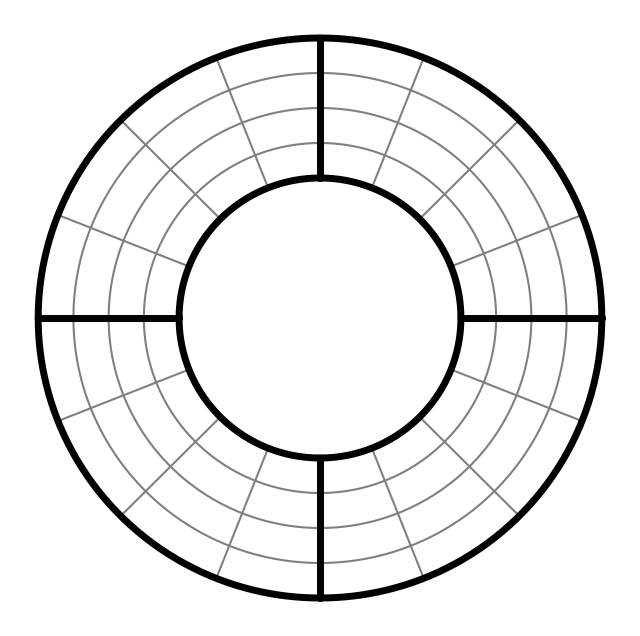

In [12]:
M.draw(bwidth=5)
plt.axis('off');

In [9]:
deg=1
n=1
kvs = (3*(bspline.make_knots(deg,0,1,n),),3*(bspline.make_knots(deg,0,1,2*n),))
geos = [
    geometry.unit_cube(),
    geometry.unit_cube().translate((1,0,0)),
    #geometry.unit_cube().translate((1,1,0))
]

patches = [(kv,geo) for kv, geo in zip(kvs,geos)]
M = topology.PatchMesh3D(patches)

In [11]:
u = lambda x,y,z: np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(np.pi*z)
f = lambda x,y,z: 3*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)*np.sin(np.pi*z)
g=u

dir_data=[
    (0,'front',g), (0,'back',g), (0,'bottom',g), (0,'top',g), (0,'left',g),
    (1,'front',g), (1,'back',g), (1,'bottom',g), (1,'top',g), (1,'right',g)
]

In [12]:
MP=Multipatch(M, b_data={'D':dir_data}, dim=3, automatch=True)

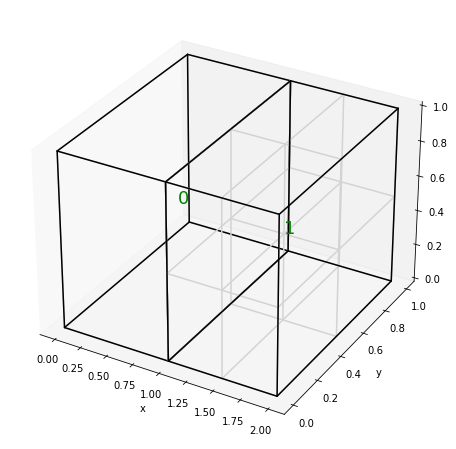

In [13]:
M.draw(patch_idx=True)

In [15]:
A, rhs, _, _, _ = MP.assemble_system(vform.stiffness_vf(3), vform.L2functional_vf(3, physical=True), f=f)

In [17]:
dir_bcs = MP.compute_dirichlet_bcs()

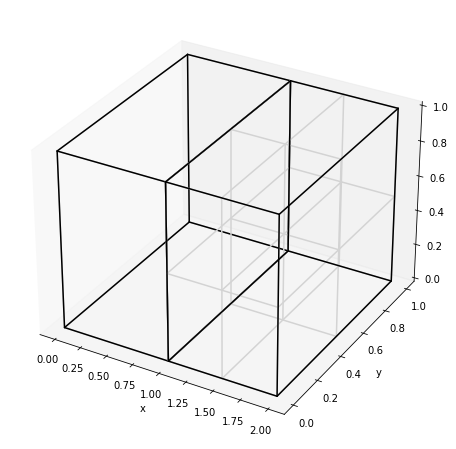

AssertionError: Input has wrong dimension

In [200]:
MP.mesh.draw()
supp=[geo.support for (_,geo),_ in MP.mesh.patches]
for (kvs, geo),_ in MP.mesh.patches:
    supp=geo.support
    x=np.clip(np.linspace(supp[1][0],supp[1][1],kvs[1].numdofs),supp[1][0]+0.015,supp[1][1]-0.015)
    y=np.clip(np.linspace(supp[0][0],supp[0][1],kvs[0].numdofs),supp[0][0]+0.015,supp[0][1]-0.015)
    #X,Y = np.meshgrid(x,y)
    #idx = (X>0.015) & (X<1-0.015) & (Y>0.015) & (Y<1-0.015)
    idx1 = bitwise_and(x>0.015, x<1-0.015)
    idx2 = bitwise_and(y>0.015, y<1-0.015)
    G = geo.grid_eval((x[idx1],y[idx2]))
    pyplot.plot(G[:,:,0], G[:,:,1], 'bo')
    #pyplot.plot(X, Y, 'bo', marker='o', color='royalblue')
    
    x=np.linspace(supp[1][0],supp[1][1],kvs[1].numdofs)
    y=np.linspace(supp[0][0],supp[0][1],kvs[0].numdofs)
    bidx = ~(idx1[None].T@idx2[None])
    G = geo.grid_eval((x,y))
    pyplot.plot(G[bidx,0], G[bidx,1],'ro')
pyplot.show()

In [21]:
# Define the exact solution and right-hand side for the example problem.
#
# We use sympy to symbolically compute the Laplacian for the exact solution,
# so you may need to 'pip install sympy' to be able to run this notebook.
#
EXAMPLE = 1 # choose: 1 or 2
x0, y0 = 0.5, 0.5
def generate_u_rhs(example):
    import sympy
    from sympy.vector import gradient
    from sympy.abc import x, y, e
    from sympy.utilities.lambdify import lambdify
    
    # specify the manufactured solution
    if example == 1:
        r2 = (x-x0)**2 + (y-y0)**2
        u = sympy.sin(1 / (e + r2))
    elif example == 2:
        r = sympy.sqrt((x-x0)**2 + (y-y0)**2)
        denom = e + sympy.tanh(12*r - 7) - sympy.tanh(-7)
        u =  x * (1-x) * y * (1-y) * sympy.sin(1/ denom)
    
    # symbolically compute the Laplacian for the right-hand side
    Lu = sympy.diff(u, x, x) + sympy.diff(u, y, y)
    #symbolically compute the gradient for the solution u
    ux, uy = sympy.diff(u,x), sympy.diff(u,y)
    
    return (lambdify((x, y, e), u, 'numpy'),
            lambdify((x, y, e), -Lu, 'numpy'),
            lambdify((x, y, e), ux, 'numpy'),
            lambdify((x, y, e), uy, 'numpy'))

sympy_u, sympy_rhs, sympy_grad_ux, sympy_grad_uy = generate_u_rhs(EXAMPLE)

dim = 2
eps = 1e-2
    
def u(x, y):
    return sympy_u(x, y, eps)

def ux(x, y):
    return sympy_grad_ux(x, y, eps)

def uy(x, y):
    return sympy_grad_uy(x, y, eps)

def f(x, y):
    return sympy_rhs(x, y, eps)

In [23]:
#Example 1

#setup initial discretization 
deg = 1
N=2
kvs = 2*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

# define geometry
geos = [
    geometry.unit_square(),
    geometry.unit_square().rotate_2d((pi/2)).translate((2,0))
]

patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)

#g = lambda x,y: 0
g=u

dir_data = [
    (0, 'right', g), (0, 'bottom', g), (0, 'left', g), (0, 'top', g)
]

MP=Multipatch(M, b_data={'D':dir_data}, automatch=True)
MP.patch_refine(patches=1)

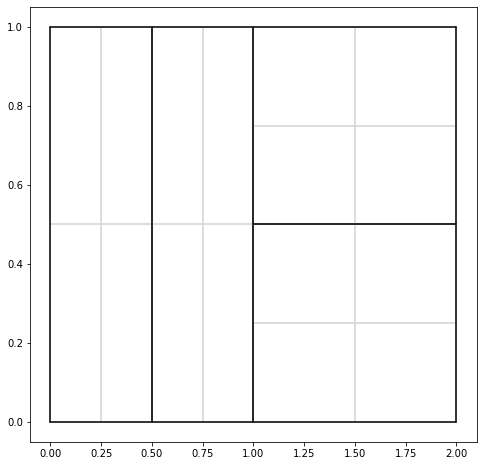

In [24]:
M.draw()

0


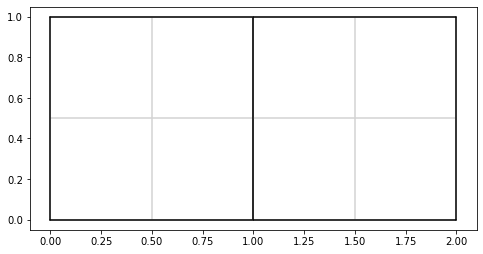

TypeError: __init__() got an unexpected keyword argument 'k'

In [25]:
uh, numdofs, L2err, H1err = uniform(copy.copy(M), dir_data, f, u, ux, uy, maxiter=5, plotrange=(-1,1))

0


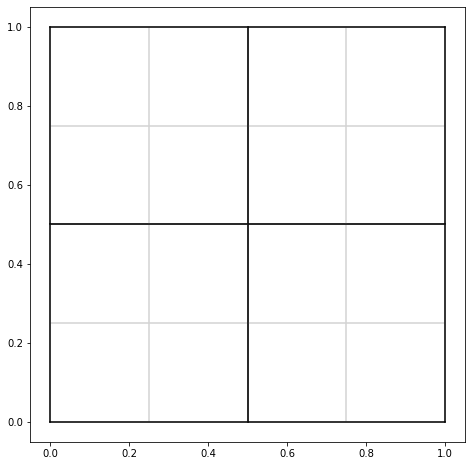

RuntimeError: Factor is exactly singular

In [75]:
uh, numdofs_a, L2err_a, H1err_a, err_est_a = adaptive(copy.copy(M), dir_data, f, u, ux, uy, theta=0.9, maxiter=5, plotrange=(-1,1))

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, L2err, 'o-',color='royalblue')
plt.loglog(numdofs_a, L2err_a, 'o-',color='darkorange')
plt.loglog(numdofs[3:5],[2*1e7/n**(2) for n in numdofs[3:5]],linestyle='--',color='royalblue')
plt.legend(['uniform','adaptive','DoFs$^{-2}$'],loc='lower left',prop={'size': 12})
plt.show()

In [ ]:
log(H1err[1:]/H1err[:-1])/log(1/4)

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, H1err, 'o-',color='royalblue')
plt.loglog(numdofs_a, H1err_a, 'o-',color='darkorange')
plt.loglog(numdofs[3:5],[4*1e7/n**(3/2) for n in numdofs[3:5]],linestyle='--',color='royalblue')
plt.legend(['uniform','adaptive','DoFs$^{-3/2}$'],loc='lower left',prop={'size': 12})
plt.show()

In [ ]:
H1err_a

In [ ]:
for geo in geos:
    vis.plot_field(u, geo,res=600)
plt.axis('scaled')
colorbar()

In [ ]:
#Example 2

#setup initial discretization 
deg = 2
N=4
kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-pi/2).translate((-2, 1))
]

patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)

gamma=3.
f = lambda x, y: 4*(x**2+y**2)*gamma**2*pi**2*sin(gamma*(x**2+y**2)*pi)-4*gamma*pi*cos(gamma*(x**2+y**2)*pi)
u = lambda x, y: sin(gamma*(x**2+y**2)*pi)
ux = lambda x, y: 2*x*gamma*pi*cos(gamma*(x**2+y**2)*pi)
uy = lambda x, y: 2*y*gamma*pi*cos(gamma*(x**2+y**2)*pi)
g = u

dir_data = [
    (0, 'right', g), (0, 'bottom', g), (0, 'left', g),
    (1, 'top', g), 
    (2, 'right', g), (2, 'bottom', g), (2, 'left', g), 
    (3, 'right', g), (3, 'bottom', g), (3, 'left', g),
]

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, L2err, 'o-')
plt.loglog(numdofs_a, L2err_a, 'o-')

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, H1err, 'o-')
plt.loglog(numdofs_a, H1err_a, 'o-')

In [ ]:
for geo in geos:
    vis.plot_field(u, geo,res=600, physical=True, vmin=-1, vmax=1)
plt.axis('scaled')
colorbar()

In [212]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0

In [213]:
deg=2
N=4
M, dir_data = Lshape(deg,N,g=u)
u_, numdofs_a, L2err_a, H1err_a, err_est_a = adaptive(M, dir_data, f, u, ux, uy, theta=0.9, maxiter=20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


0


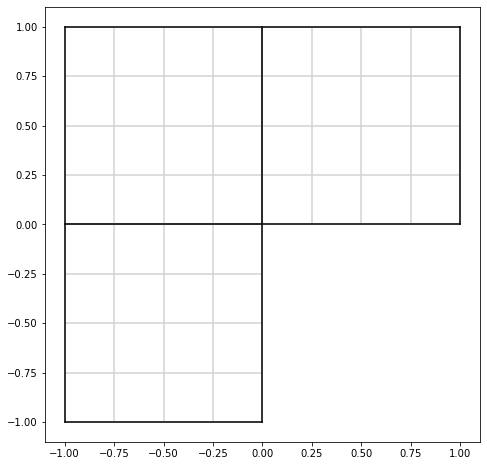

TypeError: __init__() missing 1 required positional argument: 'dir_data'

In [214]:
M, dir_data = Lshape(deg, N, g=u)
u_, numdofs, L2err, H1err = uniform(M, dir_data, f, u, ux, uy, maxiter=6)

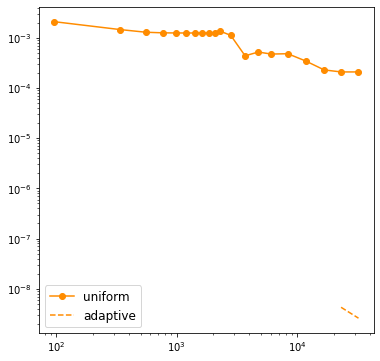

In [215]:
plt.figure(figsize=(6,6))
#plt.loglog(numdofs, L2err, 'o-',color='royalblue')
plt.loglog(numdofs_a, L2err_a, 'o-',color='darkorange')
#plt.loglog(numdofs[3:5],[0.02/n**(2/3) for n in numdofs[2:4]],linestyle='--',color='royalblue')
plt.loglog(numdofs_a[18:22],[0.015/n**(3/2) for n in numdofs_a[18:22]],linestyle='--',color='darkorange')
plt.legend(['uniform','adaptive','DoFs$^{-2/3}$','DoFs$^{-3/2}$'],loc='lower left',prop={'size': 12})
plt.show()

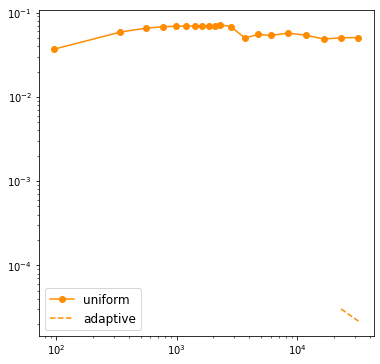

In [217]:
plt.figure(figsize=(6,6))
#plt.loglog(numdofs, H1err, 'o-',color='royalblue')
plt.loglog(numdofs_a, H1err_a, 'o-',color='darkorange')
#plt.loglog(numdofs[3:5],[0.04/n**(1/3) for n in numdofs[2:4]],linestyle='--',color='royalblue')
plt.loglog(numdofs_a[18:22],[0.7/n**(2/2) for n in numdofs_a[18:22]],linestyle='--',color='darkorange')
plt.legend(['uniform','adaptive','DoFs$^{-1/3}$','DoFs$^{-1}$'],loc='lower left',prop={'size': 12})
plt.show()

In [ ]:
fig=plt.figure(figsize=(5,5))
for ((_,geo),_) in M.patches:
    vis.plot_field(u, geo,res=600, physical=True, vmin=0, vmax=1)
plt.axis('scaled')
colorbar()

In [ ]:
#Example 4

# source term f and Dirichlet boundary function g
def generate_u_rhs():
    import sympy
    from sympy.abc import x, y, e
    from sympy.utilities.lambdify import lambdify
    
    # specify the manufactured solution
    u= x * sympy.sin(1 / (e + x**2))
    
    # symbolically compute the Laplacian for the right-hand side
    Lu = sympy.diff(u, x, x) + sympy.diff(u, y, y)
    ux, uy = sympy.diff(u,x), sympy.diff(u,y)
    return (lambdify((x, y, e), u, 'numpy'),
            lambdify((x, y, e), -Lu, 'numpy'),
            lambdify((x, y, e), ux, 'numpy'),
            lambdify((x, y, e), uy, 'numpy'))

sympy_u, sympy_rhs, sympy_ux, sympy_uy = generate_u_rhs()

eps = 1e-2

def u(x, y):
    return sympy_u(x, y, eps)

def f(x, y):
    return sympy_rhs(x, y, eps)

def ux(x, y):
    return sympy_ux(x, y, eps)

def uy(x, y):
    return 0.

In [ ]:
deg=2
N=8
M, dir_data = Annulus(deg, N, g=u)
u_, numdofs_a, L2err_a, H1err_a, err_est_a = adaptive(M, dir_data, f, u, ux, uy, theta=0.9, plotrange=(-0.85,0.85), maxiter=11)

In [ ]:
M, dir_data = Annulus(deg, N, g=u)
u_, numdofs, L2err, H1err = uniform(M, dir_data, f, u, ux, uy, plotrange=(-0.85,0.85), maxiter=6)

In [ ]:
fig=plt.figure(figsize=(5,5))
for ((_,geo),_) in M.patches:
    vis.plot_field(u, geo,res=600, physical=True, vmin=-0.85, vmax=0.85)
plt.axis('scaled')
colorbar()

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, L2err, 'o-',color='royalblue')
plt.loglog(numdofs_a, L2err_a, 'o-',color='darkorange')
plt.loglog(numdofs_a[7:],[0.1*1e6/n**(3/2) for n in numdofs_a[7:]],linestyle='--',color='red')
plt.legend(['uniform','adaptive','DoFs$^{-3/2}$'],loc='lower left',prop={'size': 12})
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs, H1err, 'o-',color='royalblue')
plt.loglog(numdofs_a, H1err_a, 'o-',color='darkorange')
plt.loglog(numdofs_a[7:-1],[0.7*1e6/n**(2/2) for n in numdofs_a[7:-1]],linestyle='--',color='red')
plt.legend(['uniform','adaptive','DoFs$^{-1}$'],loc='lower left',prop={'size': 12})
plt.show()

In [ ]:
log(H1err[1:]/H1err[:-1])/log(1/2)

In [ ]:
fig=plt.figure(figsize=(10,10))
for geo in geos:
    vis.plot_field(g, geo,res=600, physical=True, vmin=-0.85, vmax=0.85)
plt.axis('scaled')
colorbar()
plt.show()

In [ ]:
# Define the exact solution and right-hand side for the example problem.
#
# We use sympy to symbolically compute the Laplacian for the exact solution,
# so you may need to 'pip install sympy' to be able to run this notebook.
#
EXAMPLE = 1  # choose: 1 or 2

def generate_u_rhs(example):
    import sympy
    from sympy.abc import x, y, e
    from sympy.utilities.lambdify import lambdify
    
    # specify the manufactured solution
    if example == 1:
        r2 = (x-0.5)**2 + (y-0.5)**2
        u = x * (1-x) *y *(1-y) * sympy.sin(1. / (e + r2))
    elif example == 2:
        r = sympy.sqrt((x-0.5)**2 + (y-0.5)**2)
        denom = e + sympy.tanh(12*r - 7) - sympy.tanh(-7)
        u = x * (1-x) * y * (1-y) * sympy.sin(1 / denom)
    
    # symbolically compute the Laplacian for the right-hand side
    Lu = sympy.diff(u, x, x) + sympy.diff(u, y, y)
    return (lambdify((x, y, e), u, 'numpy'),
            lambdify((x, y, e), -Lu, 'numpy'))

sympy_u, sympy_rhs = generate_u_rhs(EXAMPLE)

dim = 2
eps = 1e-2

def u_exact(x, y):
    return sympy_u(x, y, eps)

def f(x, y):
    return sympy_rhs(x, y, eps)

In [ ]:
#adaptive Example

maxiter = 14

#setup initial discretization 
deg = 2
N=4
kvs = 4*((bspline.make_knots(deg, 0.0, 1.0, N), bspline.make_knots(deg, 0.0, 1.0, N)),)

# define geometry
geos = [
    geometry.unit_square()
]

patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)

# source term f and Dirichlet boundary function g
gamma=10
x0, y0 = 0.5, 0.5
#f = lambda x, y: 4*((x-x0)**2+(y-y0)**2)*gamma**2*pi**2*sin(((x-x0)**2+(y-y0)**2)*gamma*pi)-4*gamma*pi*cos(((x-x0)**2+(y-y0)**2)*gamma*pi)
#g = lambda x,y: sin(((x-x0)**2+(y-y0)**2)*gamma*pi)

g=u_exact

dir_data = [
    (0, 'left', g), (0, 'bottom', g), (0, 'right', g), (0, 'top', g)
]

M.split_patches(dir_data=dir_data)
M.split_patches(dir_data=dir_data)

for iter in range(maxiter):

    MP = Multipatch(M, automatch = True)

    #implement Dirichlet boundary conditions
    bcs = MP.compute_dirichlet_bcs(dir_data)

    # assemble the linear system
    A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

    #eliminate boundary conditions
    LS = RestrictedLinearSystem(A, rhs, bcs)
    uh = LS.complete(solvers.make_solver(LS.A, spd=False).dot(LS.b))

    err_ind = PoissonEstimator(MP,f,uh)
    
    if iter== maxiter - 1:
        break

    marked_patches = doerfler_marking(err_ind, theta=0.9)
    
    M.split_patches(marked_patches,dir_data=dir_data)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    M.draw(vertex_idx = False, patch_idx = False)
    plt.axis('scaled');
    plt.show()
    
# restrict solution to each individual patch
u_funcs = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ uh) for p in range(len(MP.mesh.patches))]